# LDDMM vs Metamorphoses
## Figure from the article.


We start by opening the pictures and preparing all variable we need.

device selected :  cuda:0


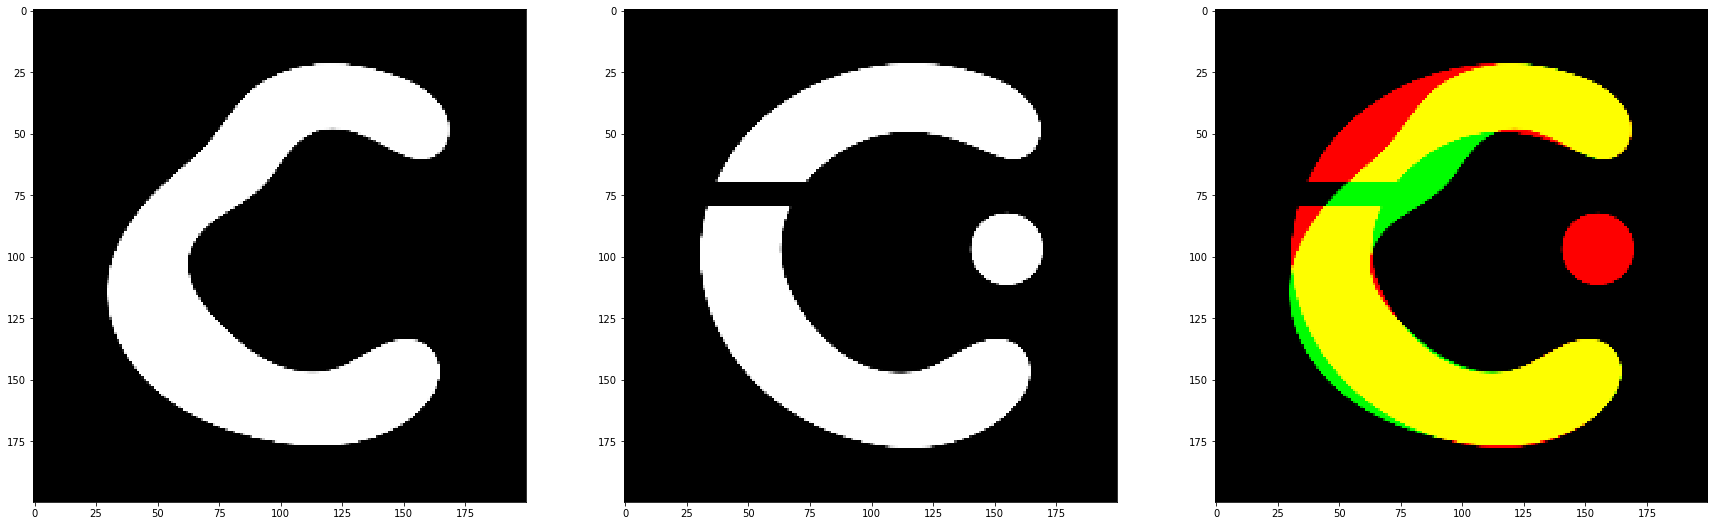

In [2]:
import torch
import time
import kornia.filters as flt
import matplotlib.pyplot as plt


from my_toolbox import update_progress,format_time#, get_freer_gpu
import my_torchbox as tb
import vector_field_to_flow as vff
import metamorphosis as mt


plt.rcParams['figure.figsize'] = [10,20]
size = (200,200)
S = tb.reg_open('m0t',size = size)
T = tb.reg_open('m1',size = size)
T[:,:,70:80,:100] = 0
# T=T*S.max()
if size is None:
    _,_,H,W = S.shape
    size = (H,W)
else:
    H,W = size

if False:
    sig = 1
    smooth = flt.GaussianBlur2d((sig*6+1,sig*6+1), (sig, sig))
    S = smooth(S)
    T = smooth(T)


id_grid = tb.make_regular_grid(size)
field = id_grid.clone()


# Select gpu or cpu
cuda = torch.cuda.is_available()
device = 'cpu'
if cuda:
    device = torch.device('cuda:0')
   # device = get_freer_gpu()
    
print('device selected : ',device)

residuals_l = torch.zeros(size)
residuals_l.requires_grad = True
residuals_l.to(device)
residuals_m = torch.zeros(size)
residuals_m.requires_grad = True
residuals_m.to(device)

plt.rcParams['figure.figsize'] = [30,10]
fig,ax = plt.subplots(1,3)
ax[0].imshow(S[0,0,:,:],cmap='gray',vmin=0,vmax=1)
ax[1].imshow(T[0,0,:,:],cmap='gray',vmin=0,vmax=1)
ax[2].imshow(tb.imCmp(S,T),vmin=0,vmax=1)

Now let's run the experiments,

The optimisation can take some time depending on the GPU you have, if you want to save some time you can load the initials residuals $z_0$ and use a smaller number of iterations (five will be enough). If you do so, note that you have to load images of the right size (150x150).

In [ ]:
# If you want to load the residuals, 
residuals_l = torch.load('residuals_banks/residuals_fig_mu00_lambm6_150')
residuals_m = torch.load('residuals_banks/residuals_fig_mu035_lambm6_150')



Percent: [##########] 100% Done...00001% 
Computation done in :  0:00:06s and 0.169cents
Percent: [##########] 100% Done...66667%  
Computation done in :  0:01:01s and 0.098cents


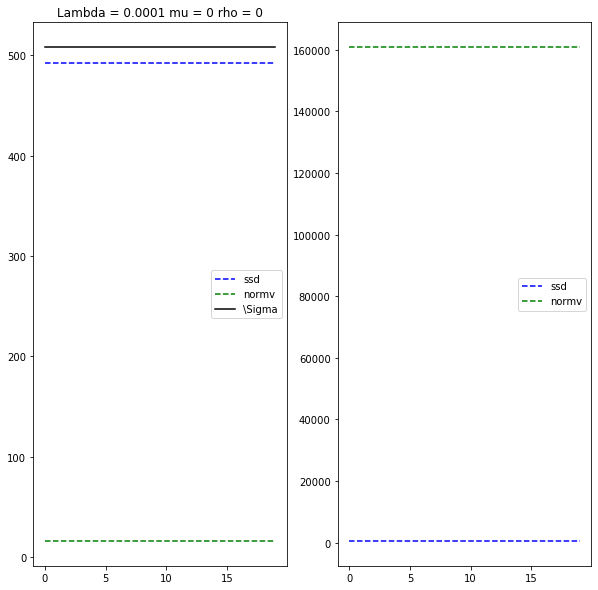

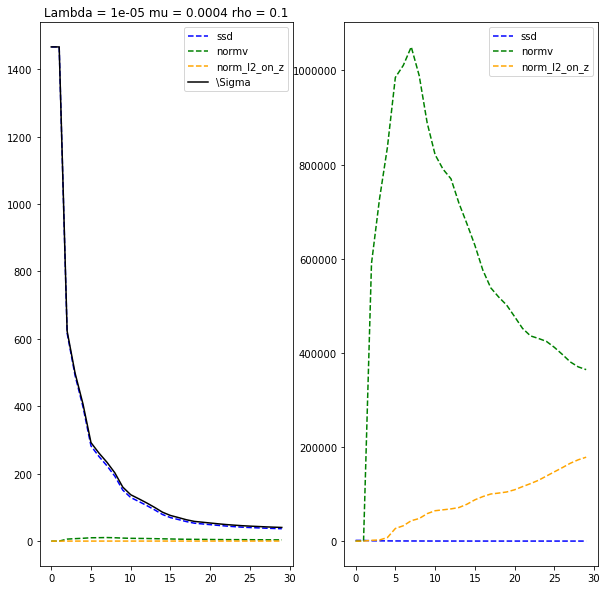

In [5]:
sigma_v = 10 # sigma of the reproducing kernel (the size of the kernel will be 3*sigma_v)
n_step = 10  # the time step will be dt = 1/n_step
n_iter = 20 # gradient descent iterations.
grad_dt = 5000 # gradient descent multiplicator

# LDDMM optimisation
start = time.time()
mu,lamb = (0,.0001)
# initilisation of the geodesic shooting method
mp_lddmm = mt.metamorphosis_path(method ='semiLagrangian',
                                 mu=mu,sigma_v=sigma_v,n_step=n_step)
# initialisation of the gradient descent using the geodesic shooting method
mr_lddmm = mt.optimize_geodesicShooting(S,T,mp_lddmm,
                                     dict(lamb=lamb,rho = 0),
                                     optimizer_method='LBFGS_torch')
# optimisation
mr_lddmm.forward(residuals_l,n_iter=20,grad_coef=.01)
end = time.time()
print("Computation done in : ",format_time(end - start))
mr_lddmm.plot_cost()

# Metamorphosis optimisation
start = time.time()
lamb,rho,mu = (.00001,1e-1,4e-4)
mp_meta = mt.metamorphosis_path(method ='semiLagrangian',mu=mu,sigma_v=sigma_v,n_step=n_step)
mr_meta = mt.optimize_geodesicShooting(S,T,mp_meta,
                                       dict(lamb=lamb,rho = rho),
                                       optimizer_method='LBFGS_torch')
mr_meta.forward(residuals_m,n_iter=30,grad_coef=.1)
end = time.time()
print("Computation done in : ",format_time(end - start))


mr_meta.plot_cost()

We can now save the optimized residuals for further usage

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0',
       grad_fn=<CopyBackwards>)

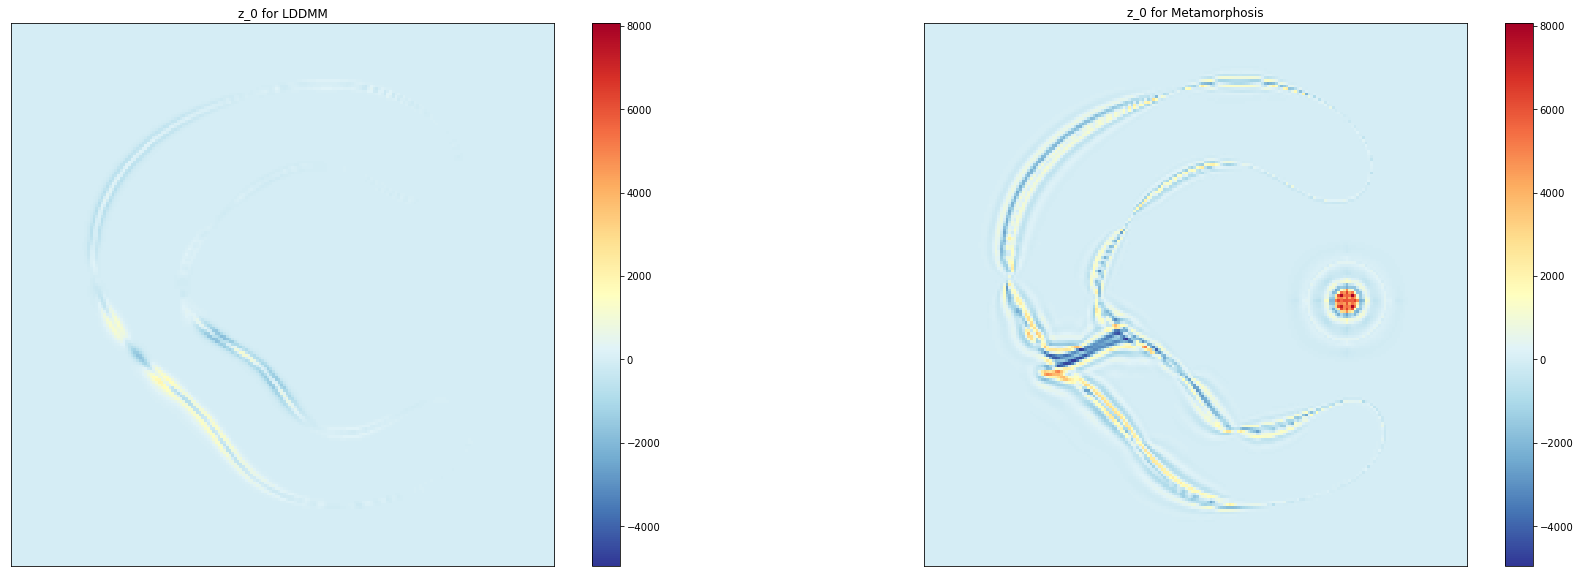

In [6]:
# recovering the optimized residuals.
residuals_l = mr_lddmm.to_analyse[0]
residuals_m = mr_meta.to_analyse[0]

kw_residuals_args = dict(cmap='RdYlBu_r',
                      extent=[-1,1,-1,1],
                      origin='lower',
                      vmin=torch.minimum(residuals_l.min(),residuals_m.min()),
                      vmax=torch.maximum(residuals_l.max(),residuals_m.max()))


# plot
plt.rcParams['figure.figsize'] = [30,10]

fig_r,ax_r = plt.subplots(1,2)
r1 = ax_r[0].imshow(residuals_l.detach(),**kw_residuals_args)
ax_r[0].set_title("z_0 for LDDMM")
fig_r.colorbar(r1,ax= ax_r[0])
r2 = ax_r[1].imshow(residuals_m.detach(),**kw_residuals_args)
ax_r[1].set_title("z_0 for Metamorphosis")
fig_r.colorbar(r2,ax= ax_r[1])
plt.setp(ax_r, xticks=[], yticks=[])

# set back parameters needed for optimisation
residuals_l.requires_grad =True
residuals_l.to(device)
residuals_m.requires_grad =True
residuals_m.to(device)

In [39]:
path = '/home/turtlefox/Documents/Doctorat/gliomorph/figs/metamorphoses/'
format = 'pdf'
fig_r.savefig(path+'c_cut_residuls_200.'+format,dpi=50,format=format,
             bbox_inches = 'tight',pad_inches = 0)

In [4]:
torch.save(residuals_l,'residuals_banks/residuals_fig_mu00_lambm6_'+str(size[0]))
torch.save(residuals_l,'residuals_banks/residuals_fig_mu035_lambm6_'+str(size[0]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


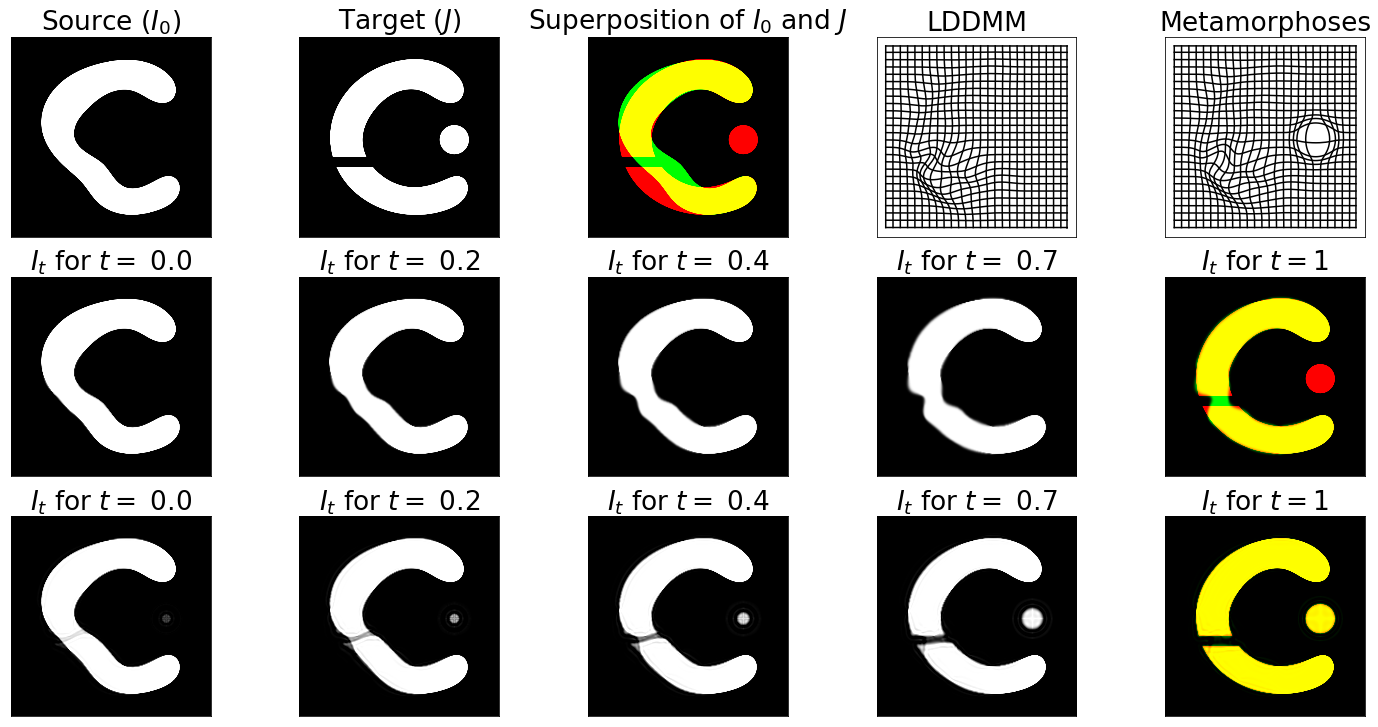

In [8]:

# Defomation computation. We compose all vectors fields from the geodesic shooting 
temporal_integrator = vff.FieldIntegrator(method='temporal',save=False,dx_convention='pixel')
# Theses deformation are used for grid plotting
deformation_lddmm = temporal_integrator(mr_lddmm.mp.field_stock/n_step,forward=True)
deformation_meta = temporal_integrator(mr_meta.mp.field_stock/n_step,forward=True)

# Theses are the inverse deformation used for actual image deformation
deformator_lddmm = temporal_integrator(mr_lddmm.mp.field_stock/n_step,forward=False)
deformator_meta = temporal_integrator(mr_meta.mp.field_stock/n_step,forward=False)


 #Plot
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 22})


kw_image_args = dict(cmap='gray',
                      #extent=[-1,1,-1,1],
                      origin='lower')

n_figs= 5

plot_id = torch.quantile(torch.arange(mp_lddmm.n_step,dtype=torch.float),
                                 torch.linspace(0,1,n_figs)).round().int()
# plot_id= plot_id[:-1]

cmap = 'gray'
kw_image_args = dict(cmap='gray',
                      extent=[-1,1,-1,1],
                      origin='lower',
                      vmin=0,vmax=1)

size_fig = 5
plt.rcParams['figure.figsize'] = [n_figs*size_fig,size_fig*3*5/6]
fig2,ax = plt.subplots(3,n_figs)

ax[0,0].imshow(S[0,0],**kw_image_args)
ax[0,0].set_title(r"Source ($I_0$)")
ax[0,1].imshow(T[0,0],**kw_image_args)
ax[0,1].set_title(r"Target ($J$)")
ax[0,2].imshow(tb.imCmp(S,T),**kw_image_args)
ax[0,2].set_title(r"Superposition of $I_0$ and $J$")

tb.gridDef_plot(deformation_lddmm,step=int(max(S.shape)/25),ax = ax[0,-2],
                         check_diffeo=False,title="LDDMM")
tb.gridDef_plot(deformation_meta,step=int(max(S.shape)/25),ax = ax[0,-1],
                         check_diffeo=False,title="Metamorphoses")

imcmp = True
if imcmp:
    plot_id = plot_id[:-1]
for i,t in enumerate(plot_id):
    i_1 =ax[1,i].imshow(mr_lddmm.mp.image_stock[t,0,:,:].detach().numpy(),
            **kw_image_args)
    ax[1,i].set_title(r"$I_t$ for $t =$ "+str((t/(mp_lddmm.n_step-1)).item())[:3])
    #fig2.colorbar(i_1,ax=ax[1,i],fraction=0.046, pad=0.04)

    i_3 =ax[2,i].imshow(mr_meta.mp.image_stock[t,0,:,:].detach().numpy(),
            **kw_image_args)
    ax[2,i].set_title(r"$I_t$ for $t =$ "+str((t/(mp_meta.n_step-1)).item())[:3])
    #fig2.colorbar(i_3,ax=ax[2,i],fraction=0.046, pad=0.04)

plt.setp(ax, xticks=[], yticks=[])

if imcmp:
    ax[1,-1].imshow(tb.imCmp(mr_lddmm.mp.image,T),**kw_image_args)
    ax[1,-1].set_title(r"$I_t$ for $t =1$")
    ax[2,-1].imshow(tb.imCmp(mr_meta.mp.image,T),**kw_image_args)
    ax[2,-1].set_title(r"$I_t$ for $t =1$")


In [43]:
path = '/home/turtlefox/Documents/Doctorat/gliomorph/figs/metamorphoses/'
format = 'pdf'
fig2.savefig(path+'c_cut_imagesFlow_200.'+format,dpi=50,format=format,
             bbox_inches = 'tight',pad_inches = 0)

The colored images are made for comparison in between two gray scale pictures, by stacking them in
separate channels. So yellows areas are where the two images matches whereas red and green area are
the image specific ones.